# Binary Mobility Prediction

**Author:** *Emese Sükei*

In this section we performed 3-fold cross validation of the pipeline. The data is imputed using iterative a pre-trained HMM for sample generation. The features are log-transformed, then normalised to be 0 mean and 1 standard deviation. 

![title](../img/pipeline.png)

## Utils

In [ ]:
# path settings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# imports
import torch
import multiprocessing as mp 

from src.utils.visualisation import *
from src.utils.constants import demogr_cols, slots_cols_dict
from src.utils.modelling import *
from src.utils.data_loader import MobilityDataModule

import warnings
warnings.filterwarnings('ignore')
    
# set autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
hparams_d = {
    'hmm_path': module_path + '/results/hmm/7_state_hmm.p',
    'add_posteriors': False,
    'only_posteriors': False,
    'data_path': module_path+'/data/eB2_das_slots_labelled_cv_set.csv',
    'x_t_cols': slots_cols_dict,
    'x_d_cols': demogr_cols,
    'y_col': 'WHODAS_mobility_bin',
    'seq_len': 30,
    'batch_size': 64,
    'num_workers': mp.cpu_count(),
    'random_split': True,
    'train_test_split': ([], [], []),
    'train_split': 0.8,
    'test_set_only': False,
    'regression': False,
    'autoregression': False,
    'with_demogr': True,
    'use_all': True,
    'verbose': True
}

hparams_d_tst = {
    'hmm_path': module_path + '/results/hmm/7_state_hmm.p',
    'add_posteriors': False,
    'only_posteriors': False,
    'data_path': module_path+'/data/eB2_das_slots_labelled_test_set.csv',
    'x_t_cols': slots_cols_dict,
    'x_d_cols': demogr_cols,
    'y_col': 'WHODAS_mobility_bin',
    'seq_len': 30,
    'batch_size': 64,
    'num_workers': mp.cpu_count(),
    'random_split': False,
    'train_test_split': ([], [], []),
    'train_split': None,
    'test_set_only': True,
    'regression': False,
    'autoregression': False,
    'with_demogr': True,
    'use_all': True,
    'verbose': True
}

hparams_m = {
    'input_dim': 4,
    'embedding_dim': 16,
    'activation': 'sin',
    'hidden_dim_1': 32,
    'hidden_dim_2': 16,
    'bidirectional': False,
    'n_layers': 2,
    'rnn_type': 'LSTM',
    'dropout': 0.1,
    'demogr_input_dim': 0,
    'output_dim': 4,
    'use_t2v': True
}

# create dataloaders
data_module_tst = MobilityDataModule(hparams_d_tst)
test_loader = data_module_tst.test_dataloader()

## Train the pipeline

### Cross-validation on different train-test splits

In [3]:
chk_path = module_path + '/results/binary_clf/no_tl/'
cv_results = cross_validate(None, chk_path, hparams_m, hparams_d, n_splits=3)

#### Plot loss evolution and ROC on minimum validation loss models

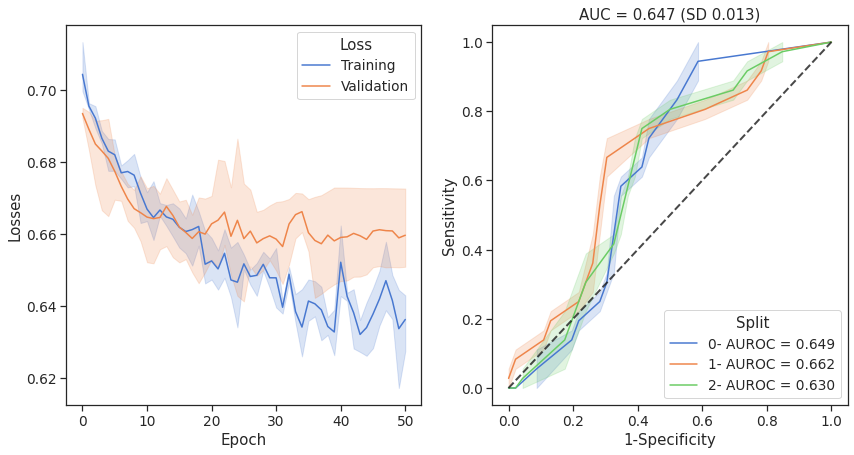

In [4]:
plot_cv_losses_and_roc(cv_results, figsize=(14, 7))

#### Plot confusion matrix over the folds on minimum validation loss models

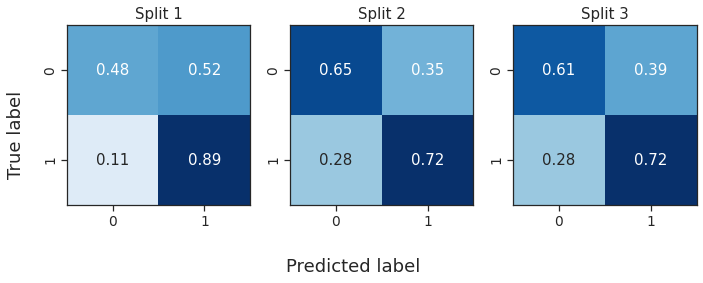

In [5]:
plot_cv_cm(cv_results, [0,1], figsize=(10,4))

#### Evaluate Best Min. Val. Model on Test Set

In [6]:
# load model from checkpoint
model, optim = init_model_and_optim(None, hparams_m, 1, 'classification', False)
optim.load_ckp(chk_path + 'fold_1_min_val_model.pt')

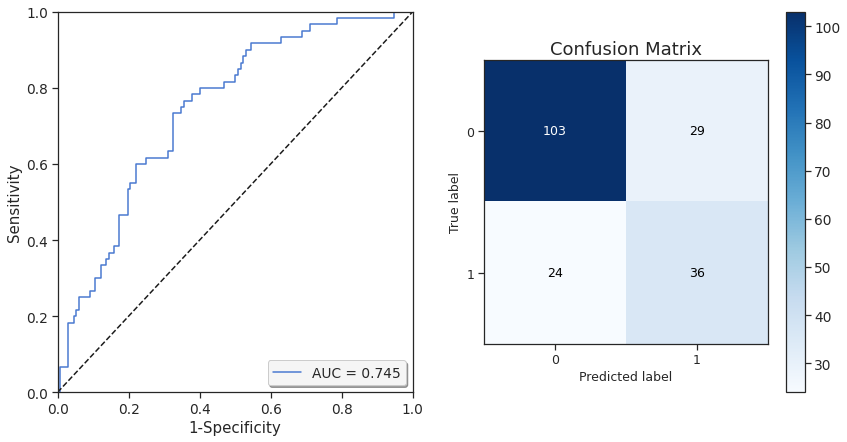

In [7]:
# evaluate the model
y_scores, y_true = optim.evaluate(test_loader, no_attentions=False)
plot_roc_and_cm(y_true, y_scores, figsize=(14, 7))

#### Compute ROC on best overall checkpoint

In [8]:
# select the checkpoint where the mean validation loss over the splits is the minimum
ckp_idx = get_best_ckp_idx(cv_results, 3, 50)
print('Min. avg. val. loss model at checkpoint {}'.format(ckp_idx))

Min. avg. val. loss model at checkpoint 31


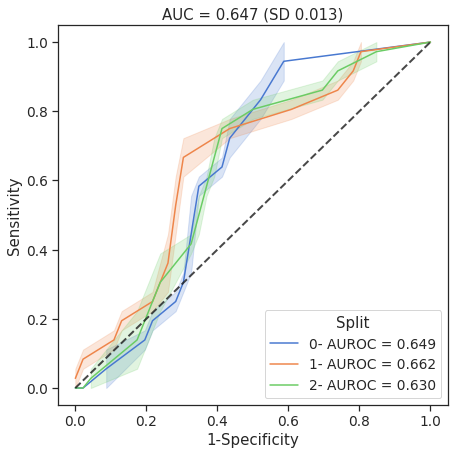

In [9]:
# evaluate each fold on this checkpoint
cv_results_no_tl = cross_validate(None, chk_path, hparams_tl, hparams_d, n_splits=3, n_epochs=50,
                                  task='classification', feature_extract=False, strat_col=None, no_attention=False,
                                  no_training=True, split_break=3, ckp_to_load='ckp_ep_' + str(ckp_idx+1) + '.pt', verbose=False)

plot_cv_roc(cv_results_no_tl, n_classes=2, figsize=(7, 7))

#### Evaluate Best Min. Avg. Val. Model on Test Set

In [8]:
# load model from checkpoint
model, optim = init_model_and_optim(None, hparams_tl, 1, 'classification', False)
optim.load_ckp(chk_path + 'fold_1_' + 'ckp_ep_' + str(ckp_idx+1) + '.pt')

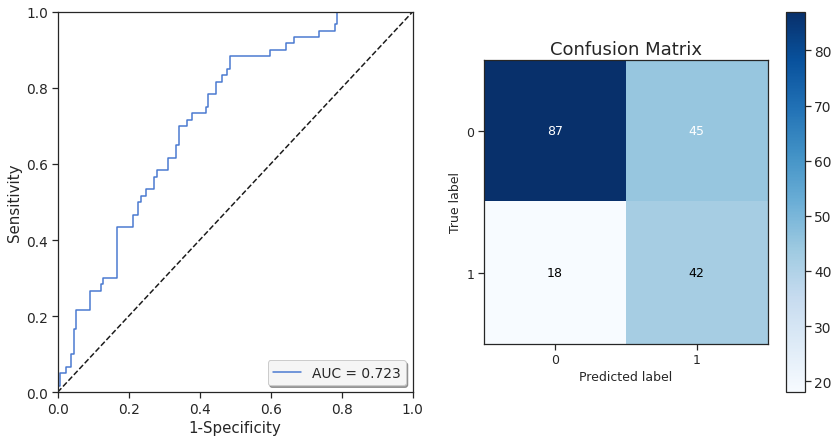

In [9]:
# evaluate the model
y_scores, y_true = optim.evaluate(test_loader, no_attentions=False)
plot_roc_and_cm(y_true, y_scores, figsize=(14, 7))

### Plot Attentions in Best Model

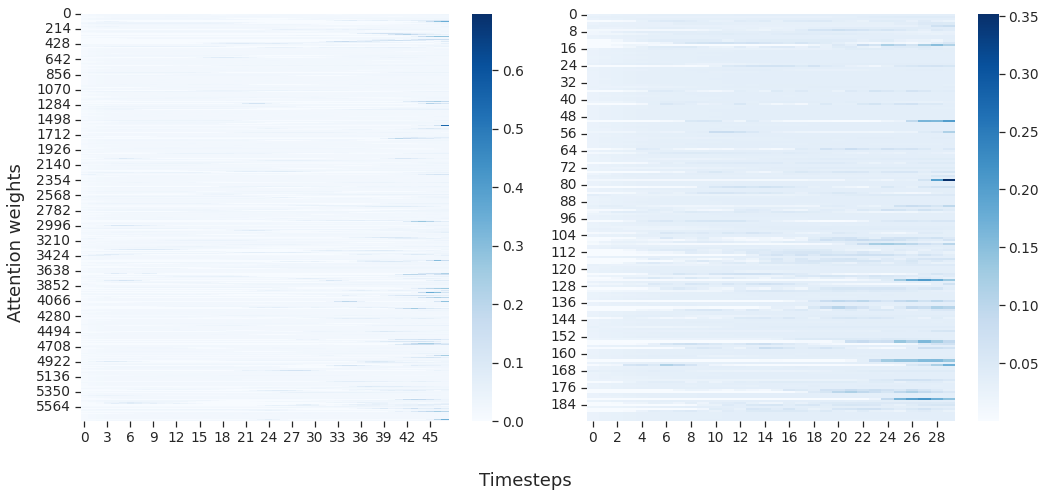

In [10]:
# get and plot attention weights 
daily_atts, monthly_atts = optim.get_attentions(test_loader)
plot_attentions(daily_atts, monthly_atts)

### Analyse the folds

#### Plot no. samples per patient in each fold

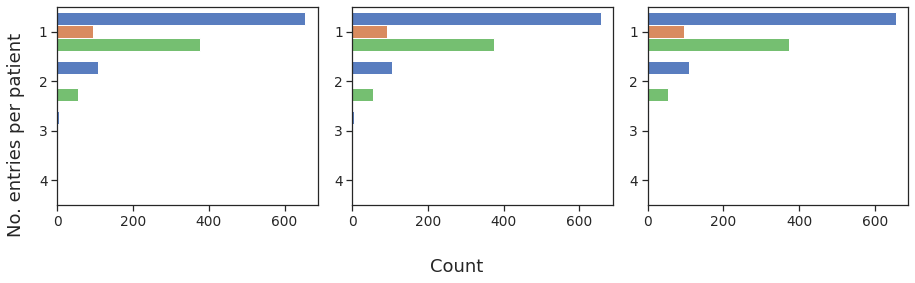

In [11]:
plot_cv_labels_per_patient(cv_results)

#### Plot no. changes per patient in each fold

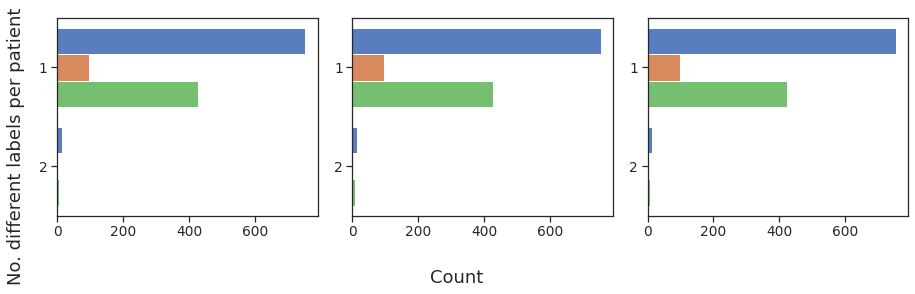

In [12]:
df = pd.read_csv(hparams_d['data_path']).dropna(subset=[hparams_d['y_col']])
plot_cv_diff_labels_per_patient(cv_results, df, hparams_d['y_col'])

#### Missingness in each fold

In [ ]:
hparams_d['verbose'] = False
miss_info = get_cv_missingness(hparams_d, n_splits=3, strat_col=None)

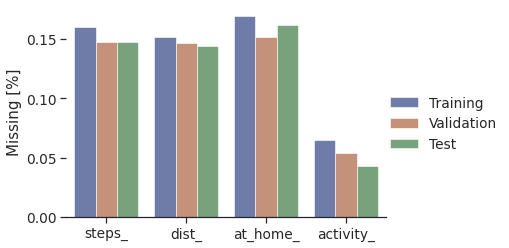

In [14]:
# Draw a nested barplot by Dataset and Feature
g = sns.catplot(
    data=miss_info, kind='bar',
    x='Feature', y='Missing [%]', hue='Dataset',
    ci='sd', palette='dark', alpha=.6, height=4, aspect=1.5
)
g.despine(left=True)
g.set_axis_labels('', 'Missing [%]')
g.legend.set_title('')

# Binary Mobility Prediction with Transfer Learning

The temporal part of the model is pre-trained for the auto-regressive part of predicting the mean of the following 30-days of activity. Then the model is initialised with the so-found weights and re-trained to perform the mobility classification task. 

![title](../img/transf_learning.png)

## Pre-training

### Create datahandlers

In [ ]:
# define data loader parameters
hparams_d_pr = {
    'hmm_path': module_path + '/results/hmm/hmm_slots/7_state_hmm.p',
    'add_posteriors': False,
    'only_posteriors': False,
    'data_path': module_path+'/data/interim/eB2_das_slots.csv',
    'x_t_cols': slots_cols_dict,
    'seq_len': 30,
    'batch_size': 100,
    'num_workers': mp.cpu_count(),
    'random_split': True,
    'train_split': 0.85,
    'train_test_split': ([], [], []),
    'test_set_only': False,
    'regression': True,
    'autoregression': True,
    'with_demogr': False,
    'use_all': True,
    'verbose': True
}

data_module_pr = MobilityDataModule(hparams_d_pr)

train_loader_pr = data_module_pr.train_dataloader()
val_loader_pr = data_module_pr.val_dataloader()
test_loader_pr = data_module_pr.test_dataloader()

### Create the model

In [ ]:
from src.models.pred_model import MobilityPredictor

hparams_pr = {
    'input_dim': 4,
    'embedding_dim': 16,
    'activation': 'sin',
    'hidden_dim_1': 32,
    'hidden_dim_2': 16,
    'bidirectional': False,
    'n_layers': 2,
    'rnn_type': 'LSTM',
    'dropout': 0.1,
    'output_dim': 4,
    'use_t2v': True
}

model = MobilityPredictor(hparams_pr)

print(model)

MobilityPredictor(
  (embedding): T2V()
  (encoder_1): Encoder(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.1)
  )
  (attention_1): Attention()
  (encoder_2): Encoder(
    (rnn): LSTM(32, 16, num_layers=2, batch_first=True, dropout=0.1)
  )
  (attention_2): Attention()
  (fc): Linear(in_features=16, out_features=4, bias=True)
)


### Create the Optimiser

In [ ]:
from src.utils.optimisation import RegressorTrainer

# MSE loss and Adam optimiser with an initial learning rate of 0.001
optim = RegressorTrainer(
    model,
    torch.nn.MSELoss(),
    torch.optim.Adam(model.parameters(), lr=0.01),
    clip=100
)

### Train the Model

In [ ]:
ckp_path = None
optim.train(train_loader_pr, val_loader_pr, n_epochs = 10, checkpoint_path = ckp_path)

### Checking the predictions

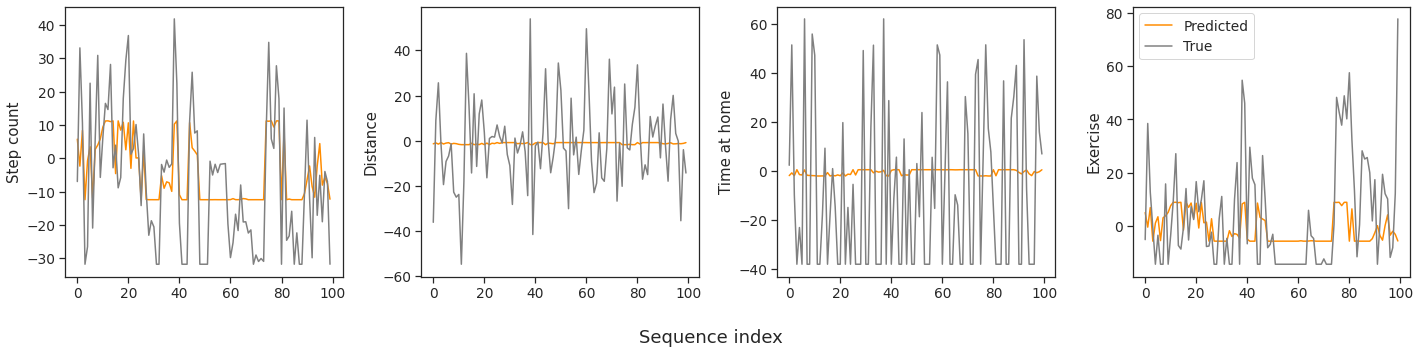

In [ ]:
optim.load_ckp(ckp_path + 'ckp_ep_10.pt')
y_pred, y_true = optim.evaluate(test_loader_pr)
plot_autoregression_pred(y_pred, y_true, 
                         ['Step count', 'Distance', 'Time at home', 'Exercise'], figsize=(20, 5))

## Transfer learning 

In this section we will perform two types of transfer learning: finetuning and feature extraction. In finetuning, we start with a pretrained model, and update all of the model’s parameters for our new task, in essence retraining the whole model. In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. In both cases we reshape the last layer, and add an extra fully connected one on top of it for the predictions. 

In general both transfer learning methods follow the same few steps:
* Initialise the pretrained model
* Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
* Define for the optimisation algorithm which parameters we want to update during training
* Run the training step

In [ ]:
# path to the pre-trained model
pre_trained_path = module_path + '/results/pre_training/ckp_ep_10.pt'

### Finetuning

#### Cross-validation on different train-test splits

In [ ]:
chk_path = module_path + '/results/binary_clf/tl/ft_'
cv_results = cross_validate(pre_trained_path, chk_path, hparams_tl, hparams_d, n_splits=3, 
                            n_epochs=50, task='classification', feature_extract=False)

##### Plot loss evolution and ROC on minimum validation loss models

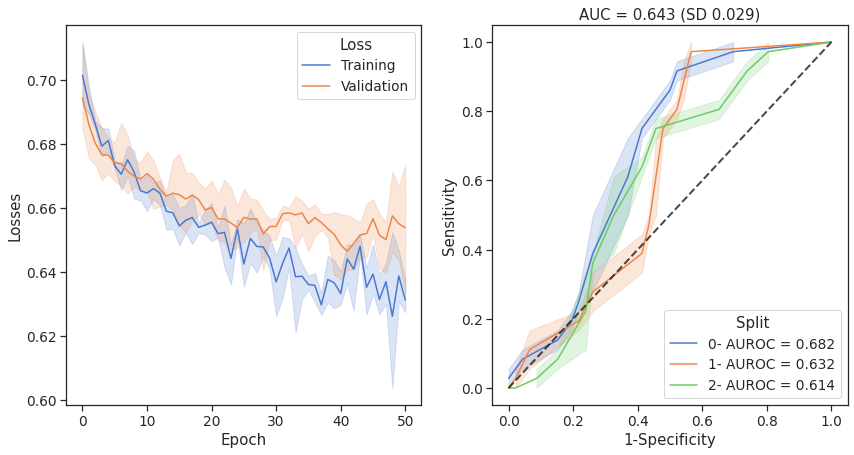

In [ ]:
plot_cv_losses_and_roc(cv_results, figsize=(14, 7))

##### Plot confusion matrix over the folds on minimum validation loss models

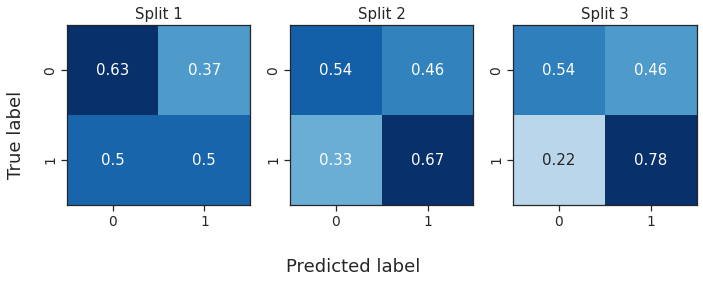

In [ ]:
plot_cv_cm(cv_results, [0,1], figsize=(10,4))

#### Evaluate Best Min. Val. Model on Test Set

In [ ]:
# load model from checkpoint
model, optim = init_model_and_optim(pre_trained_path, hparams_tl, 1, 'classification', False)
optim.load_ckp(chk_path + 'fold_0_min_val_model.pt')

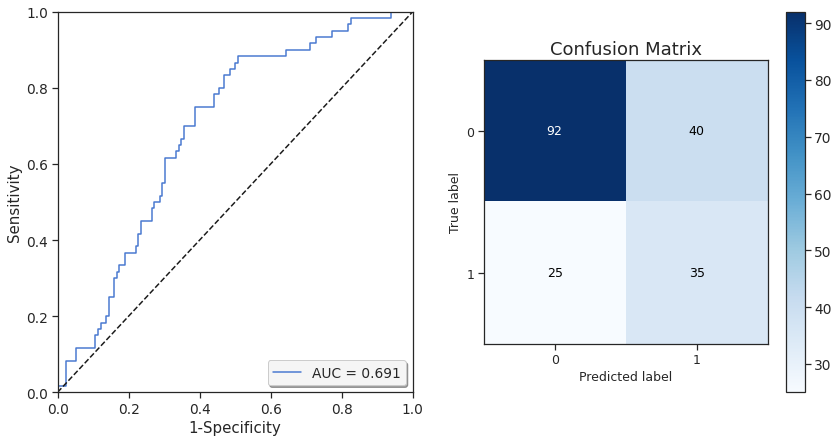

In [ ]:
# evaluate the model
y_scores, y_true = optim.evaluate(test_loader, no_attentions=False)
plot_roc_and_cm(y_true, y_scores, figsize=(14, 7))

##### Compute ROC on best overall checkpoint

In [ ]:
# select the checkpoint where the mean validation loss over the splits is the minimum
ckp_idx = get_best_ckp_idx(cv_results, 3, 50)
print('Min. avg. val. loss model at checkpoint {}'.format(ckp_idx))

Min. avg. val. loss model at checkpoint 41


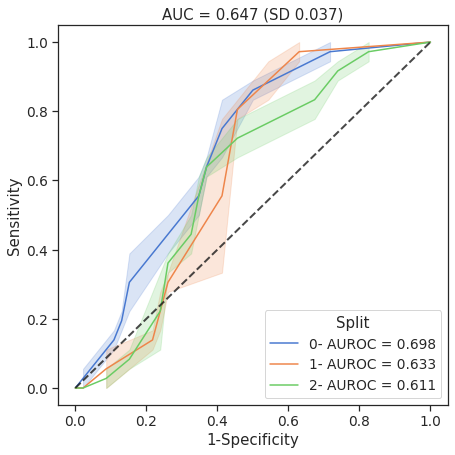

In [ ]:
# evaluate each fold on this checkpoint
ckp_idx = 30
cv_results_tl = cross_validate(pre_trained_path, chk_path, hparams_tl, hparams_d, n_splits=3, n_epochs=50,
                               task='classification', feature_extract=False, strat_col=None, no_attention=False,
                               no_training=True, split_break=3, ckp_to_load='ckp_ep_' + str(ckp_idx+1) + '.pt', verbose=False)

plot_cv_roc(cv_results_tl, n_classes=2, figsize=(7, 7))

##### Evaluate Best Min. Avg. Val. Model on Test Set

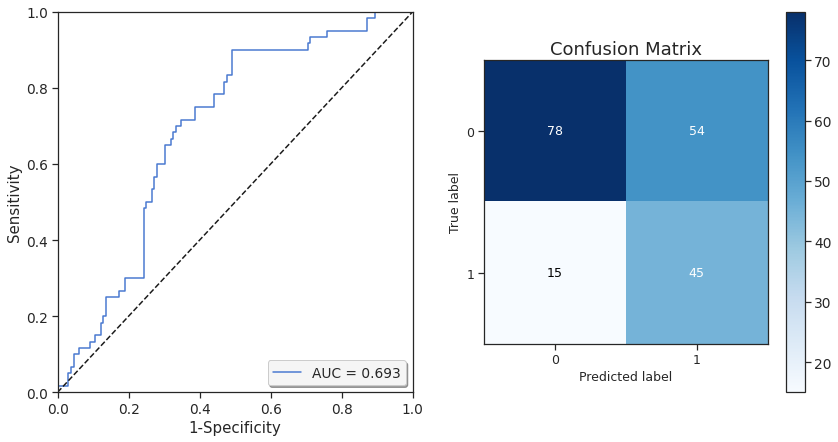

In [ ]:
# load model from checkpoint
model, optim = init_model_and_optim(pre_trained_path, hparams_tl, 1, 'classification', False)
optim.load_ckp(chk_path + 'fold_0_' + 'ckp_ep_' + str(ckp_idx+1) + '.pt')

# evaluate the model
y_scores, y_true = optim.evaluate(test_loader, no_attentions=False)
plot_roc_and_cm(y_true, y_scores, figsize=(14, 7))

### Feature extraction

#### Cross-validation on different train-test splits

In [ ]:
chk_path = module_path + '/results/binary_clf/tl/fe_'
cv_results = cross_validate(pre_trained_path, chk_path, hparams_tl, hparams_d, n_splits=3, 
                            n_epochs=50, task='classification', feature_extract=True)

##### Plot loss evolution and ROC on minimum validation loss models

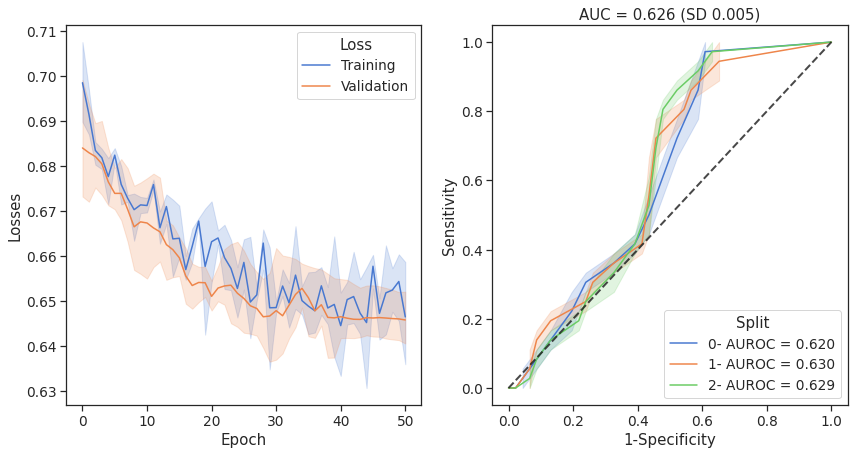

In [ ]:
plot_cv_losses_and_roc(cv_results, figsize=(14, 7))

##### Plot confusion matrix over the folds on minimum validation loss models

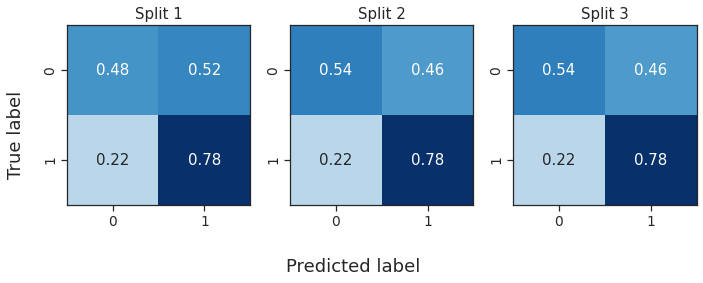

In [ ]:
plot_cv_cm(cv_results, [0,1], figsize=(10,4))

#### Evaluate Best Min. Val. Model on Test Set

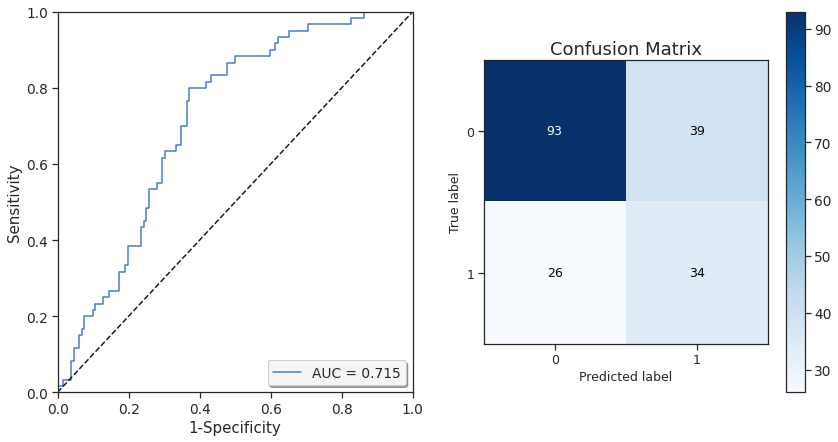

In [ ]:
# load model from checkpoint
model, optim = init_model_and_optim(pre_trained_path, hparams_tl, 1, 'classification', feature_extract=True, no_attention=False)
optim.load_ckp(chk_path + 'fold_1_min_val_model.pt')

# evaluate the model
y_scores, y_true = optim.evaluate(test_loader, no_attentions=False)
plot_roc_and_cm(y_true, y_scores, figsize=(14, 7))

##### Compute ROC on best overall checkpoint

In [ ]:
# select the checkpoint where the mean validation loss over the splits is the minimum
ckp_idx = get_best_ckp_idx(cv_results, 3, 50)
print('Min. avg. val. loss model at checkpoint {}'.format(ckp_idx))

Min. avg. val. loss model at checkpoint 43


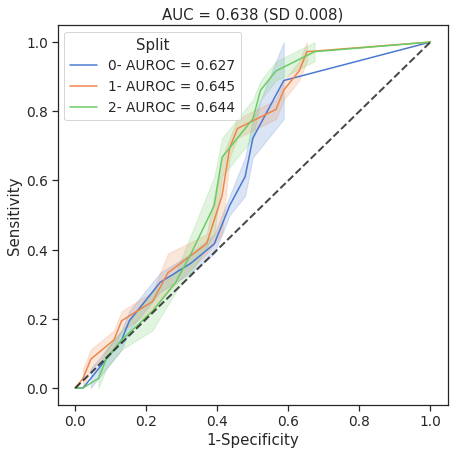

In [ ]:
# evaluate each fold on this checkpoint
ckp_idx = 30
cv_results_tl = cross_validate(pre_trained_path, chk_path, hparams_tl, hparams_d, n_splits=3, n_epochs=50,
                               task='classification', feature_extract=True, strat_col=None, no_attention=False,
                               no_training=True, split_break=3, ckp_to_load='ckp_ep_' + str(ckp_idx+1) + '.pt', verbose=False)

plot_cv_roc(cv_results_tl, n_classes=2, figsize=(7, 7))

##### Evaluate Best Min. Avg. Val. Model on Test Set

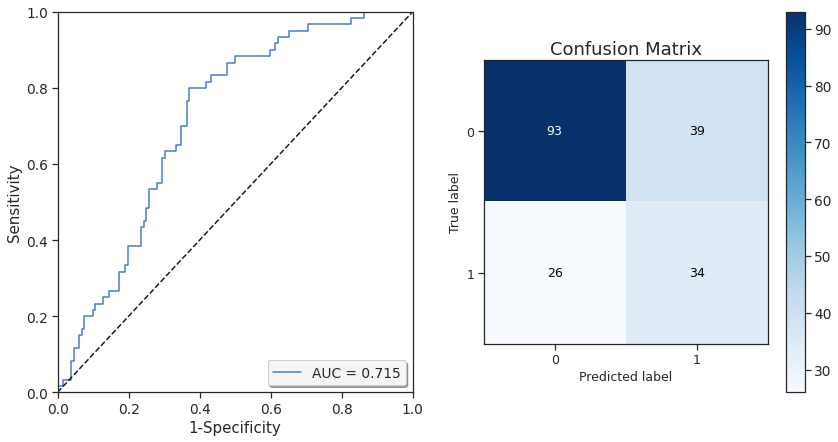

In [ ]:
# load model from checkpoint
model, optim = init_model_and_optim(pre_trained_path, hparams_tl, 1, 'classification', feature_extract=True, no_attention=False)
optim.load_ckp(chk_path + 'fold_1_' + 'ckp_ep_' + str(ckp_idx+1) + '.pt')

# evaluate the model
y_scores, y_true = optim.evaluate(test_loader, no_attentions=False)
plot_roc_and_cm(y_true, y_scores, figsize=(14, 7))